<a href="https://colab.research.google.com/github/HoseinNekouei/US_Airline_Sentiment_Classification/blob/main/Gemini_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Augmentaion via Gemini 1.0 pro

In [1]:
! pip install datasets transformers

In [1]:
import google.generativeai as genai
import textwrap

from google.colab import userdata

In [2]:
# added Google API key in secret manager

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY_ATENA')
genai.configure(api_key=GOOGLE_API_KEY)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from datasets import load_dataset

# Load the CSV file in memory
dataset_url= '/content/drive/MyDrive/dataset/US_airline/Tweets-augmented.csv'

#load dataset
raw_data = load_dataset('csv', data_files=dataset_url, sep=',')
raw_data['train']= raw_data['train'].filter(lambda x: x['airline_sentiment_confidence']>= 0.9 )
# raw_data['train']= raw_data['train'].select_columns(['text', 'airline_sentiment', 'airline_sentiment_confidence'])
raw_data

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/21718 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone'],
        num_rows: 21718
    })
})

In [6]:
model= genai.GenerativeModel('gemini-1.0-pro')

generation_config= genai.types.GenerationConfig(
    candidate_count=1,
    max_output_tokens=36,
    # stop_sequences=['\n'],
    top_k=1,
    temperature=1.0
)

In [7]:
# Define generator function
def generate_text(model, prompt,generation_config):
  """
    Arguments:
      model(obj):
        The model used for text generation
      promt(str):
        The input prompt for text generation
      generation_config:
        A 'genai.GenerationConfig' object setting the default generation parameters to use

    Returns:
      str: The generated text response from the model
  """
  response = model.generate_content(
    prompt,
    safety_settings= {'HARM_CATEGORY_HARASSMENT': 'BLOCK_NONE'},
    generation_config= generation_config
  )

  return response


In [8]:
def create_sample(sentiment, input_prompt):
  """
  Generates a sample text response using a specified model and prompt, associating it with a given sentiment.

  Args:
      sentiment (str): The sentiment associated with the generated text.
      input_prompt (str): The prompt used to generate the text.

  Returns:
      dict: A dictionary containing the generated text response, the associated sentiment, and a confidence score.
  """
  response = generate_text(model, prompt,generation_config)
  result= {'text': response.text, 'airline_sentiment': sentiment, 'airline_sentiment_confidence': 1.0}

  return result

In [20]:
import time

print(f"total sample: {len(raw_data['train'])}")

for index in range(3):

  if index % 2==0:
    prompt='Generate the positive tweet about the US airline start with the name of an Us airline and @'
    sentiment= 'positive'
  else:
    prompt='Generate the neutral tweet about the US airline start with the name of an Us airline and @'
    sentiment='neutral'

  raw_data['train'] = raw_data['train'].add_item(create_sample(sentiment, prompt))

  if (index+1) % 10 == 0:

    # save the new dataset into csv file
    raw_data['train'].to_csv('/content/drive/MyDrive/dataset/US_airline/Tweets-augmented.csv')

    print('Dataset was updated in index:', (index+1))

  time.sleep(5) # Add a 5 second delay between requests

total sample: 22170


df_original_dataset: 10458
df_augmented_dataset: 22173

airline_sentiment
negative    7391
neutral     1550
positive    1517
Name: count, dtype: int64
airline_sentiment
neutral     7391
negative    7391
positive    7391
Name: count, dtype: int64


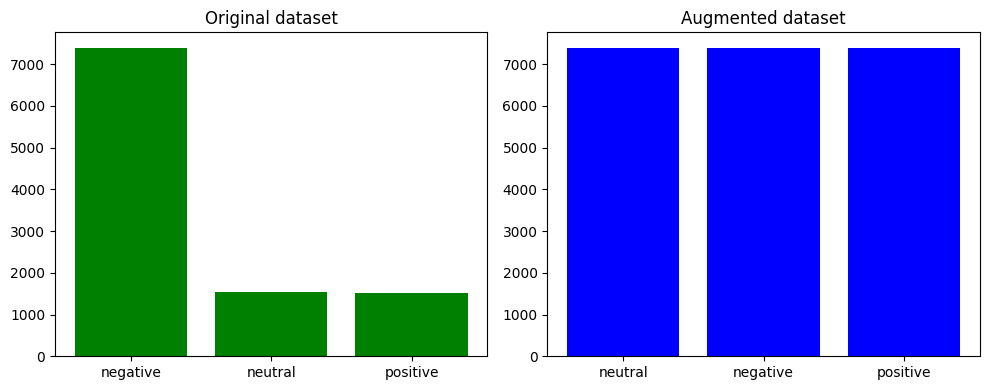

In [22]:
import matplotlib.pyplot as plt
import pandas

orginal_dataset_url='/content/drive/MyDrive/dataset/US_airline/Tweets.csv'
original_dataset = load_dataset('csv', data_files= orginal_dataset_url)
original_dataset['train']= original_dataset['train'].filter(lambda x: x['airline_sentiment_confidence']>= 0.9 )


# train_labels = dataset.set_format('pandas')
df_original_dataset= original_dataset['train'].to_pandas()
df_augmented_dataset= raw_data['train'].to_pandas()

print(f'df_original_dataset: {len(df_original_dataset)}')
print(f'df_augmented_dataset: {len(df_augmented_dataset)}')

df_original = df_original_dataset['airline_sentiment'].value_counts()
df_augmented = df_augmented_dataset['airline_sentiment'].value_counts()

print('')
print(df_original)
print(df_augmented)

# Plot the bar chart for train and test label distributions
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.bar(df_original.index, df_original.values, color= 'green')
plt.title('Original dataset')

plt.subplot(1, 2, 2)
plt.bar(df_augmented.index, df_augmented.values, color='blue')
plt.title('Augmented dataset')

plt.tight_layout()
plt.show()